<a href="https://colab.research.google.com/github/filipp134/vk_bot_detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install eli5
!pip install shap
!pip install xgboost
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from xgboost.sklearn import XGBClassifier
import joblib
import eli5
from eli5.sklearn import PermutationImportance
import shap
import json
%matplotlib inline

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/filipp134/vk_bot_detection/main/Dataset_for_VK_project.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Exploring data

In [36]:
df.head()

,uid,has_photo,sex,has_mobile,followers_count,contacts,relatives,relation,personal,activities,...,deg_centr,average_neighbor_degree,average_degree_connectivity,k_nearest_neighbors,degree_centrality,closeness_centrality,betweenness_centrality,diameter,average_shortest_path_length,target
0,648249344,0,2,1.0,0.0,0,1,1,1,1,...,1.000000,6.482493e+08,0.000000,0.000000,1.000000,0.000000,0.000000,0,0,0
1,645333001,1,2,1.0,2.0,0,0,0,0,0,...,0.257143,2.612393e+08,7.508862,7.508862,0.257143,0.588401,0.057143,2,1,0
2,651165709,1,2,1.0,9.0,0,1,1,1,1,...,0.038501,4.023961e+08,34.912425,34.912425,0.038501,0.511661,0.006917,2,1,0
3,649232401,1,1,1.0,0.0,0,0,0,0,0,...,1.000000,6.492324e+08,0.000000,0.000000,1.000000,0.000000,0.000000,0,0,0
4,639664147,0,1,1.0,1.0,0,1,1,1,1,...,0.260000,3.456780e+08,10.625207,10.625207,0.260000,0.584422,0.032174,2,1,0


In [37]:
df.shape

(11766, 40)

In [38]:
df.columns

Index(['uid', 'has_photo', 'sex', 'has_mobile', 'followers_count', 'contacts',
       'relatives', 'relation', 'personal', 'activities', 'music', 'movies',
       'tv', 'books', 'about', 'quotes', 'albums', 'audios', 'followers',
       'friends', 'pages', 'photos', 'subscriptions', 'videos',
       'clips_followers', 'age', 'city', 'country', 'avg_cl', 'trans',
       'deg_centr', 'average_neighbor_degree', 'average_degree_connectivity',
       'k_nearest_neighbors', 'degree_centrality', 'closeness_centrality',
       'betweenness_centrality', 'diameter', 'average_shortest_path_length',
       'target'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11766 entries, 0 to 11765
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   uid                           11766 non-null  int64  
 1   has_photo                     11766 non-null  int64  
 2   sex                           11766 non-null  int64  
 3   has_mobile                    11766 non-null  float64
 4   followers_count               11766 non-null  float64
 5   contacts                      11766 non-null  int64  
 6   relatives                     11766 non-null  int64  
 7   relation                      11766 non-null  int64  
 8   personal                      11766 non-null  int64  
 9   activities                    11766 non-null  int64  
 10  music                         11766 non-null  int64  
 11  movies                        11766 non-null  int64  
 12  tv                            11766 non-null  int64  
 13  b

In [40]:
df['contacts'].value_counts()

0    11766
Name: contacts, dtype: int64

In [41]:
df.drop('contacts', axis=1, inplace=True)

In [42]:
df['subscriptions'].value_counts()

0.0      8159
1.0       805
2.0       387
3.0       285
4.0       209
         ... 
217.0       1
239.0       1
212.0       1
223.0       1
863.0       1
Name: subscriptions, Length: 214, dtype: int64

In [43]:
df[(df.friends > 0) & (df.friends < 500)].friends.describe()

count    6555.000000
mean       56.147826
std        76.464044
min         1.000000
25%         5.000000
50%        23.000000
75%        76.000000
max       499.000000
Name: friends, dtype: float64

In [44]:
df[df.friends > 0].friends.quantile(0.75)

84.0

In [45]:
df['target'].value_counts()

0    9969
1    1797
Name: target, dtype: int64

In [46]:
df[df.uid.isin(df[df.friends > 0].uid)]['target'].value_counts()

0    5180
1    1565
Name: target, dtype: int64

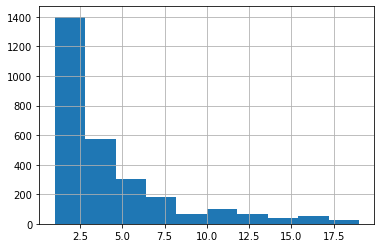

In [47]:
df[(df.followers_count < 20) & (df.followers_count >0)]['followers_count'].hist()

In [48]:
df['city'].value_counts()

0.0          8141
1.0          1164
2.0           337
49.0          116
99.0          109
             ... 
1710959.0       1
2367.0          1
1463.0          1
9620.0          1
2625.0          1
Name: city, Length: 623, dtype: int64

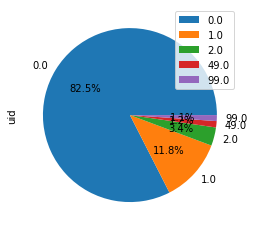

In [49]:
data_with_cities = df.groupby('city').count()
data_with_cities[data_with_cities['uid'] > 100].plot.pie(autopct="%.1f%%", y='uid')

In [50]:
df['sex'].value_counts()

1    6755
2    4960
0      51
Name: sex, dtype: int64

In [51]:
df[df['sex']==0]['target'].value_counts()

0    50
1     1
Name: target, dtype: int64

In [52]:
df[df['sex']==1]['target'].value_counts()

0    5747
1    1008
Name: target, dtype: int64

In [53]:
df[df['sex']==2]['target'].value_counts()

0    4172
1     788
Name: target, dtype: int64

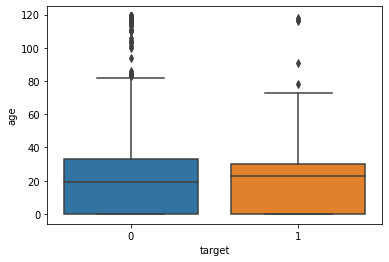

In [54]:
sns.boxplot(data=df, x='target', y='age')

In [55]:
df[df.target == 0].personal.mean()

0.5315477981743405

In [56]:
df[df.target == 1].personal.mean()

0.3110740122426266

In [57]:
df[df.target == 0].has_photo.mean()

0.5762864881131508

In [58]:
df[df.target == 1].has_photo.mean()

0.9682804674457429

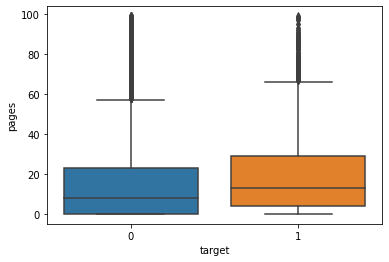

In [59]:
sns.boxplot(data=df[df['pages'] < 100], x='target', y='pages')

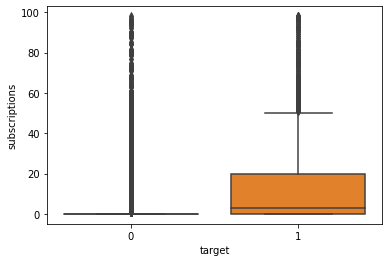

In [60]:
sns.boxplot(data=df[df['subscriptions'] < 100], x='target', y='subscriptions')

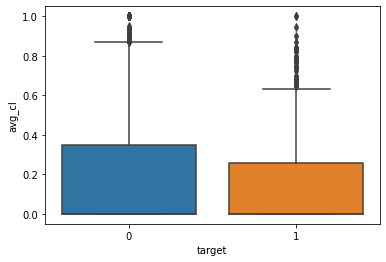

In [61]:
sns.boxplot(data=df, x='target', y='avg_cl')

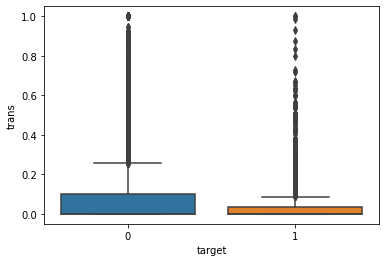

In [62]:
sns.boxplot(data=df, x='target', y='trans')

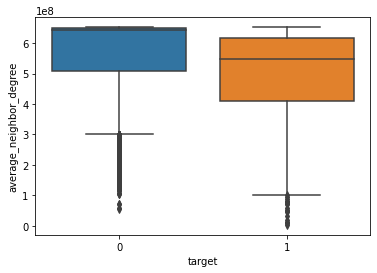

In [63]:
sns.boxplot(data=df, x='target', y='average_neighbor_degree')

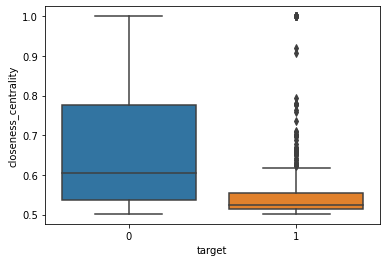

In [64]:
sns.boxplot(data=df[df['closeness_centrality'] > 0], x='target', y='closeness_centrality')

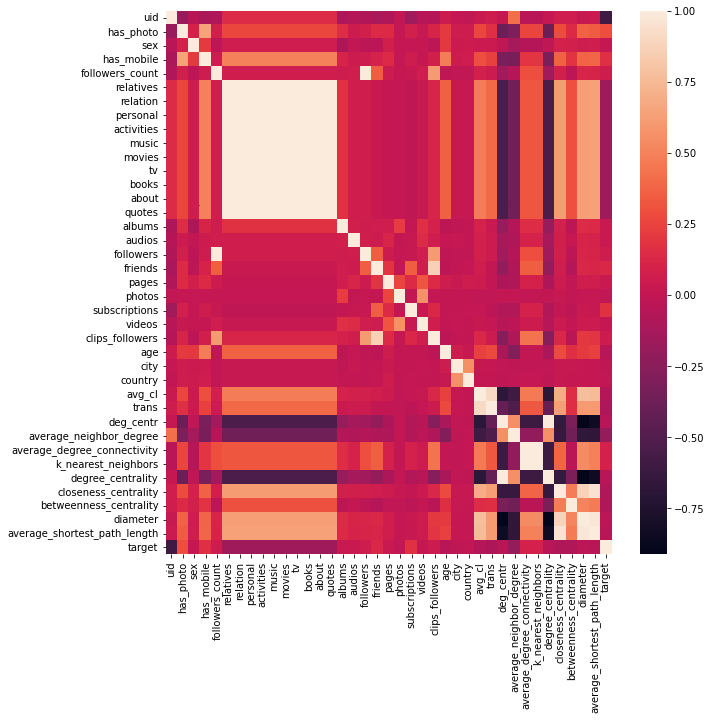

In [65]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

In [66]:
corr

,uid,has_photo,sex,has_mobile,followers_count,relatives,relation,personal,activities,music,...,deg_centr,average_neighbor_degree,average_degree_connectivity,k_nearest_neighbors,degree_centrality,closeness_centrality,betweenness_centrality,diameter,average_shortest_path_length,target
uid,1.000000,-0.182193,-0.042038,-0.100482,-0.084965,0.145527,0.145527,0.145527,0.145527,0.145527,...,0.020116,0.424484,-0.044502,-0.044502,0.020116,0.060585,0.059767,0.026345,0.036978,-0.596500
has_photo,-0.182193,1.000000,0.094739,0.645549,0.076748,0.261951,0.261951,0.261951,0.261951,0.261951,...,-0.384667,-0.302781,0.258880,0.258880,-0.384667,0.284190,0.136714,0.368414,0.349417,0.293097
sex,-0.042038,0.094739,1.000000,0.210162,-0.028334,0.059933,0.059933,0.059933,0.059933,0.059933,...,-0.014991,-0.127934,-0.064448,-0.064448,-0.014991,0.092469,0.086492,0.056460,0.071573,0.017542
has_mobile,-0.100482,0.645549,0.210162,1.000000,0.053349,0.493540,0.493540,0.493540,0.493540,0.493540,...,-0.320450,-0.327498,0.190929,0.190929,-0.320450,0.366207,0.180073,0.373837,0.383259,0.165748
followers_count,-0.084965,0.076748,-0.028334,0.053349,1.000000,0.068794,0.068794,0.068794,0.068794,0.068794,...,-0.145493,-0.053600,0.291550,0.291550,-0.145493,0.079896,-0.019278,0.118164,0.110844,0.058470
relatives,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
relation,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
personal,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
activities,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621
music,0.145527,0.261951,0.059933,0.493540,0.068794,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.529256,-0.361336,0.321946,0.321946,-0.529256,0.614529,0.300598,0.621527,0.639679,-0.158621


In [67]:
df[['relation', 'personal', 'activities', 'music', 'movies', 'tv', 'books', 'about', 'quotes']].head(10)

,relation,personal,activities,music,movies,tv,books,about,quotes
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0


In [68]:
df.drop(['relatives', 'personal', 'activities', 'music', 'movies', 'tv', 'books', 'about', 'quotes'], axis=1, inplace=True)

In [69]:
df.drop('followers_count', axis=1, inplace=True)

In [70]:
df.drop('k_nearest_neighbors', axis=1, inplace=True)

In [71]:
df.drop('deg_centr', axis=1, inplace=True)

In [72]:
df.drop('average_shortest_path_length', axis=1, inplace=True)

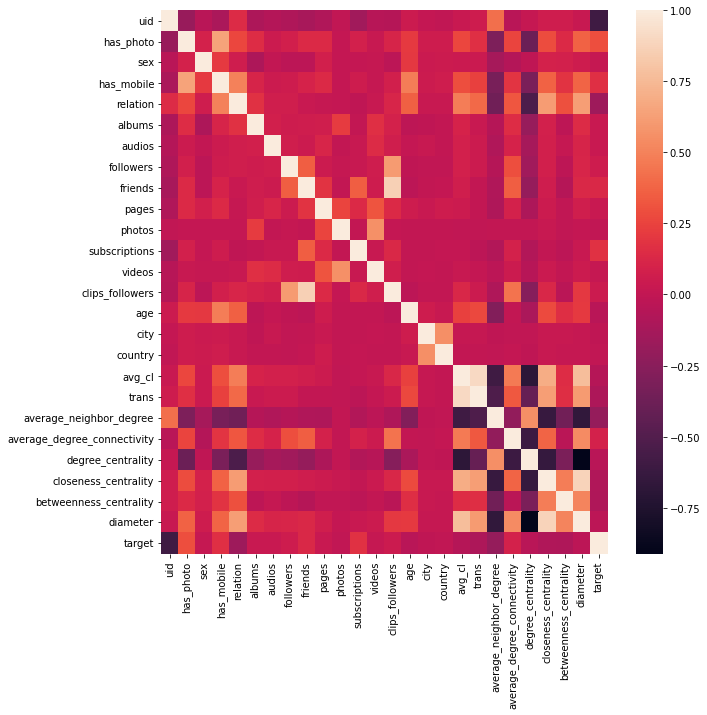

In [73]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

In [74]:
df.drop('uid', axis=1, inplace=True)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11766 entries, 0 to 11765
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   has_photo                    11766 non-null  int64  
 1   sex                          11766 non-null  int64  
 2   has_mobile                   11766 non-null  float64
 3   relation                     11766 non-null  int64  
 4   albums                       11766 non-null  float64
 5   audios                       11766 non-null  float64
 6   followers                    11766 non-null  float64
 7   friends                      11766 non-null  float64
 8   pages                        11766 non-null  float64
 9   photos                       11766 non-null  float64
 10  subscriptions                11766 non-null  float64
 11  videos                       11766 non-null  float64
 12  clips_followers              11766 non-null  float64
 13  age             

In [76]:
df.shape

(11766, 25)

# Models

In [77]:
X = df.drop('target', axis=1)
y = df['target']
X_log = df.drop('target', axis=1)
y_log = df['target']
X_log = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
X_trai, X_tes, y_trai, y_tes = train_test_split(X_log, y_log, test_size=0.2, random_state=50)

In [78]:
y.value_counts()

0    9969
1    1797
Name: target, dtype: int64

In [79]:
y_train.value_counts()

0    7976
1    1436
Name: target, dtype: int64

In [80]:
1436 / 1797

0.7991096271563717

In [81]:
1797 / 9969

0.18025880228709

In [82]:
1436 / 7976

0.18004012036108324

## Logistic Regression

In [83]:
parameters_1 = {'solver':('liblinear', 'lbfgs'), 'C':[0.5, 1, 10, 100], 'random_state':[0, 1], 'max_iter':[1000, 10000]}
model_1 = LogisticRegression()
clf_1 = GridSearchCV(model_1, parameters_1)
clf_1.fit(X_trai, y_trai)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 10, 100], 'max_iter': [1000, 10000],
                         'random_state': [0, 1],
                         'solver': ('liblinear', 'lbfgs')})

In [84]:
model_1 = LogisticRegression(solver='lbfgs', C=1.0, max_iter=10000).fit(X_trai, y_trai)

In [85]:
predictions_1 = model_1.predict_proba(X_tes)[:,1]
roc_auc_score(y_tes, predictions_1)

0.8758063193476336

In [86]:
print(classification_report(model_1.predict(X_tes), y_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2170
           1       0.43      0.84      0.57       184

    accuracy                           0.90      2354
   macro avg       0.71      0.87      0.75      2354
weighted avg       0.94      0.90      0.91      2354



In [87]:
perm = PermutationImportance(model_1, random_state=1).fit(X_trai, y_trai)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.0701 ± 0.0053,average_neighbor_degree
0.0289 ± 0.0017,closeness_centrality
0.0197 ± 0.0019,subscriptions
0.0178 ± 0.0013,relation
0.0166 ± 0.0012,trans
0.0150 ± 0.0008,has_photo
0.0121 ± 0.0013,clips_followers
0.0083 ± 0.0008,avg_cl
0.0081 ± 0.0018,betweenness_centrality
0.0066 ± 0.0026,average_degree_connectivity


## Random Forest Classification

In [88]:
parameters_2 = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'random_state':[0, 1]}
model_2 = RandomForestClassifier()
clf_2 = GridSearchCV(model_2, parameters_2)
clf_2.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'random_state': [0, 1]})

In [89]:
model_2 = RandomForestClassifier(max_depth=None, random_state=None).fit(X_train, y_train)

In [90]:
predictions_2 = model_2.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predictions_2)

0.9803766089901914

In [91]:
print(classification_report(model_2.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2073
           1       0.76      0.97      0.85       281

    accuracy                           0.96      2354
   macro avg       0.88      0.96      0.91      2354
weighted avg       0.97      0.96      0.96      2354



In [92]:
perm = PermutationImportance(model_2, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.2958 ± 0.0061,average_neighbor_degree
0.1402 ± 0.0040,has_photo
0.0932 ± 0.0018,pages
0.0102 ± 0.0011,subscriptions
0.0077 ± 0.0006,friends
0.0068 ± 0.0009,photos
0.0064 ± 0.0007,country
0.0059 ± 0.0006,followers
0.0050 ± 0.0006,clips_followers
0.0049 ± 0.0007,relation


In [93]:
joblib.dump(model_2, 'model.pkl')

['model.pkl']

## Gradient Boosting Classification

In [94]:
parameters_3 = {'n_estimators':[10, 100, 1000], 'learning_rate':[0.5, 1.0], 'max_depth':[0.1, 0.5, 1]}
model_3 = GradientBoostingClassifier()
clf_3 = GridSearchCV(model_3, parameters_3)
clf_3.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.5, 1.0],
                         'max_depth': [0.1, 0.5, 1],
                         'n_estimators': [10, 100, 1000]})

In [95]:
model_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

In [96]:
predictions_3 = model_3.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predictions_3)

0.9749108027681372

In [97]:
print(classification_report(model_3.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2067
           1       0.74      0.93      0.82       287

    accuracy                           0.95      2354
   macro avg       0.86      0.94      0.90      2354
weighted avg       0.96      0.95      0.95      2354



In [98]:
perm = PermutationImportance(model_3, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.2850 ± 0.0055,average_neighbor_degree
0.1399 ± 0.0033,has_photo
0.1148 ± 0.0012,pages
0.0671 ± 0.0046,closeness_centrality
0.0158 ± 0.0012,friends
0.0078 ± 0.0013,subscriptions
0.0059 ± 0.0004,followers
0.0039 ± 0.0010,avg_cl
0.0031 ± 0.0005,photos
0.0028 ± 0.0012,relation


 97%|=================== | 11396/11766 [00:12<00:00]       

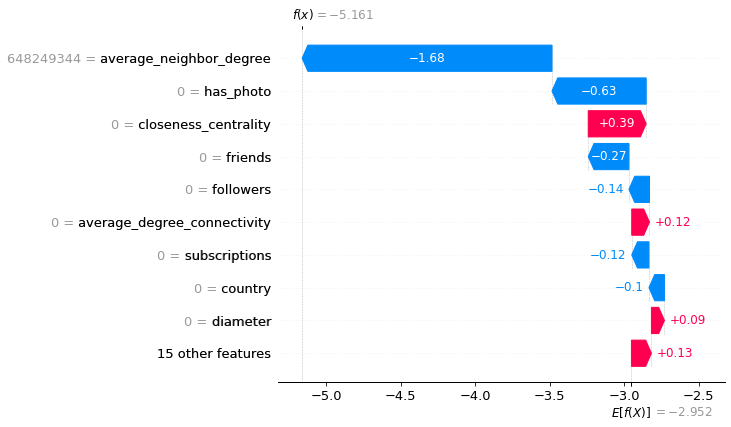

In [99]:
explainer_3 = shap.Explainer(model_3, X)
shap_values_3 = explainer_3(X)
shap.plots.waterfall(shap_values_3[0])

## XGBoosting Classification

In [100]:
parameters_4 = {'n_estimators':[10, 100, 1000], 'learning_rate':[0.5, 1.0], 'max_depth':[5, 10]}
model_4 = XGBClassifier()
clf_4 = GridSearchCV(model_4, parameters_4)
clf_4.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.5, 1.0], 'max_depth': [5, 10],
                         'n_estimators': [10, 100, 1000]})

In [101]:
model_4 = XGBClassifier().fit(X_train, y_train, verbose=False)

In [102]:
predictions_4 = model_4.predict_proba(X_test)[:,1]
roc_auc_score(y_test, predictions_4)

0.9789151225966786

In [103]:
print(classification_report(model_4.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2070
           1       0.75      0.95      0.84       284

    accuracy                           0.96      2354
   macro avg       0.87      0.95      0.91      2354
weighted avg       0.96      0.96      0.96      2354



In [104]:
perm = PermutationImportance(model_4, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = df.drop('target', axis=1).columns.to_list())

Weight,Feature
0.2843 ± 0.0057,average_neighbor_degree
0.1409 ± 0.0033,has_photo
0.1289 ± 0.0034,closeness_centrality
0.0953 ± 0.0022,pages
0.0144 ± 0.0011,friends
0.0090 ± 0.0015,subscriptions
0.0063 ± 0.0004,followers
0.0037 ± 0.0009,photos
0.0026 ± 0.0016,relation
0.0019 ± 0.0010,country


 97%|=================== | 11374/11766 [00:14<00:00]       

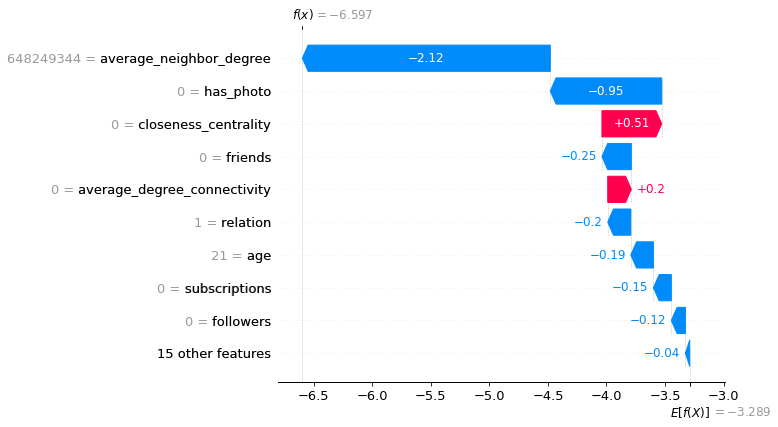

In [105]:
explainer_4 = shap.Explainer(model_4, X)
shap_values_4 = explainer_4(X)
shap.plots.waterfall(shap_values_4[0])